## IMPORT THƯ VIỆN

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.models import EfficientNet_B3_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR
# Cấu hình device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Cấu hình và EDA

Training Counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}


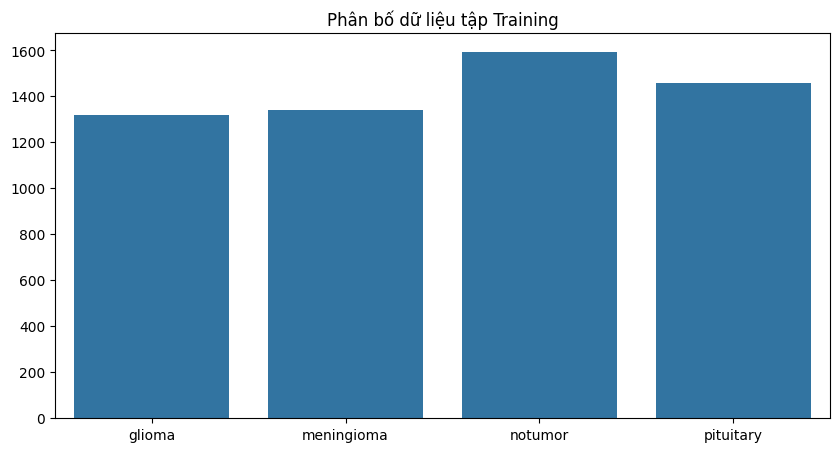

In [4]:
# CẤU HÌNH ĐƯỜNG DẪN 
DATA_DIR = '/kaggle/input/brain-tumor-mri-dataset' 
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
TEST_DIR = os.path.join(DATA_DIR, 'Testing')

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Đếm số ảnh mỗi class
def count_images(directory):
    counts = {}
    for cls in classes:
        counts[cls] = len(os.listdir(os.path.join(directory, cls)))
    return counts

train_counts = count_images(TRAIN_DIR)
print("Training Counts:", train_counts)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Phân bố dữ liệu tập Training")
plt.show()

## Tiền xử lý & Data Augmentation

In [5]:
#  Custom Dataset để load ảnh MRI não
class BrainTumorDataset(Dataset):
     #  Khởi tạo dataset
    def __init__(self, root_dir, augment=False, img_size=(224, 224)):
        self.root_dir = root_dir # Lưu đường dẫn gốc
        self.augment = augment # True cho tập Train, False cho Val/Test
        self.img_size = img_size
        self.image_paths = []      # Danh sách đường dẫn các ảnh
        self.labels = []      # Danh sách nhãn tương ứng
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        
        # Load danh sách đường dẫn ảnh
        for label_idx, cls in enumerate(self.classes):     
            cls_dir = os.path.join(root_dir, cls)
            if os.path.exists(cls_dir):
                 # Duyệt qua tất cả ảnh trong thư mục class
                for img_name in os.listdir(cls_dir):
                    self.image_paths.append(os.path.join(cls_dir, img_name))      # Thêm đường dẫn đầy đủ của ảnh
                    self.labels.append(label_idx)                                   # Thêm label tương ứng (0, 1, 2, hoặc 3)
      #Trả về số lượng ảnh trong dataset
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load ảnh bằng OpenCV (mặc định là BGR)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Chuyển sang RGB
        
        # Resize giữ tỷ lệ (Padding)
        img = resize_with_padding(img, self.img_size)
        
        # Augmentation (Chỉ áp dụng nếu là tập train)
        if self.augment:
            img = augment_image(img)
            
        #  Preprocess (CLAHE + Normalize [-1, 1])
        img = preprocess_image(img) # Kết quả là numpy array float32, shape (H, W, 3)
        
        # Chuyển sang Tensor PyTorch
        # PyTorch yêu cầu channel-first: (C, H, W)
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)
        
        # Label sang tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
            
        return img_tensor, label_tensor

In [6]:
# Cấu hình
IMG_SIZE = (300, 300)
BATCH_SIZE = 32

# Resize ảnh giữ tỷ lệ và thêm viền đen (padding)
def resize_with_padding(image, target_size=(224, 224)):
    h, w = image.shape[:2]
    target_h, target_w = target_size
    
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    resized = cv2.resize(image, (new_w, new_h))
    
    # Tạo canvas đen
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    
    # Tính offset để đặt ảnh vào giữa
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return canvas
    # Hàm Augmentation thủ công bằng OpenCV
def augment_image(img):
    #  Lật ngang (Random Horizontal Flip)
    if np.random.random() > 0.5:
        img = cv2.flip(img, 1)
        
    #  Xoay ngẫu nhiên (Random Rotation -15 đến 15 độ)
    angle = np.random.uniform(-15, 15)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h), borderValue=0)
    
    #  Thay đổi độ sáng (Random Brightness)
    factor = np.random.uniform(0.9, 1.1)
    # Cần đảm bảo kiểu dữ liệu hợp lệ sau khi nhân
    img = np.clip(img.astype(np.float32) * factor, 0, 255).astype(np.uint8)
    
    return img
    
    # CLAHE + Normalize về [-1, 1]
def preprocess_image(image):
    # Chuyển sang Grayscale để áp dụng CLAHE
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
        
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Chuyển lại sang RGB (3 kênh giống nhau) cho model
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
    
    # Normalize về khoảng [-1, 1]
    return enhanced.astype(np.float32) / 127.5 - 1.0

## Chia dữ liệu (Split Data)

In [7]:
# Tạo Dataset cho Training (
full_train_dataset = BrainTumorDataset(TRAIN_DIR, augment=True, img_size=IMG_SIZE)

# Dataset tập Train
train_dataset = BrainTumorDataset(TRAIN_DIR, augment=True, img_size=IMG_SIZE)

# Dataset tập Test gốc
temp_test_dataset = BrainTumorDataset(TEST_DIR, augment=False, img_size=IMG_SIZE)

# Chia temp_test_dataset thành Val và Test (50/50)
val_size = int(0.5 * len(temp_test_dataset))
test_size = len(temp_test_dataset) - val_size
val_dataset, test_dataset = random_split(temp_test_dataset, [val_size, test_size])

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 5712
Val size: 655
Test size: 656


## Transfer Learning với EfficientNet-B3

In [8]:
def build_model(num_classes=4):
    # Load model pre-trained
    model = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
    
    # FREEZE ALL
    for param in model.parameters():
        param.requires_grad = False   # Giữ pretrained weights, chỉ train classifier
        
    # Thay thế classifier layer cuối cùng
    num_ftrs = model.classifier[1].in_features   # 1536
    
    model.classifier = nn.Sequential( 
        nn.Dropout(p=0.3),               # Regularization
        nn.Linear(num_ftrs, num_classes)  # 1536 → 4
    )
    
    return model.to(device)

model = build_model()

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 98.6MB/s]


## Hàm đánh giá

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_phase(model, history, loader, classes, phase_name="Phase 1"):
    print(f"\n{'='*20} KẾT QUẢ {phase_name.upper()} {'='*20}")
    
    # --- Vẽ biểu đồ Accuracy & Loss ---
    epochs_range = range(1, len(history['train_acc']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # Biểu đồ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_acc'], label='Train Acc')
    plt.plot(epochs_range, history['val_acc'], label='Val Acc')
    plt.title(f'{phase_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Biểu đồ Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Val Loss')
    plt.title(f'{phase_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    plt.show()

    # --- Đánh giá trên tập Test ---
    print(f"\n>>> Đang đánh giá trên tập Test cho {phase_name}...")
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # ---  Classification Report & Confusion Matrix ---
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{phase_name} - Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

## Config Optimizer

In [10]:
# EarlyStopping dùng để dừng training sớm
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience # số epoch cho phép không cải thiện trước khi dừng
        self.verbose = verbose
        self.counter = 0          # counter: đếm số epoch liên tiếp không cải thiện
        self.best_score = None     # lưu score tốt nhất (ở đây = -val_loss)
        self.early_stop = False       # early_stop: cờ báo dừng training
        self.val_loss_min = np.inf       #validation loss nhỏ nhất từng đạt được
        self.delta = delta             #ngưỡng cải thiện tối thiểu
        self.path = path
        self.trace_func = trace_func
        
# Hàm này được gọi SAU MỖI EPOCH
    def __call__(self, val_loss, model):
        score = -val_loss
        # Epoch đầu tiên → chưa có best_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        #  # Nếu score KHÔNG cải thiện đủ delta
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        # # Nếu score cải thiện
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [11]:
# Label Smoothing Loss: Giúp model tổng quát hóa tốt hơn
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

#  Optimizer với Weight Decay (L2 Regularization) để giảm Overfitting
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

#  Learning Rate Scheduler: Tự động giảm LR nếu Val Loss không cải thiện sau 2 epoch
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

## Training Loop

In [12]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    return running_loss / len(loader), 100 * correct / total

def validate(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / len(loader), 100 * correct / total

## Huấn luyện Giai đoạn 1

In [13]:
epochs = 5
history_phase1 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Stage 1: Training Head...")
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    history_phase1['train_loss'].append(train_loss)
    history_phase1['train_acc'].append(train_acc)
    history_phase1['val_loss'].append(val_loss)
    history_phase1['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

Stage 1: Training Head...
Epoch 1/5 - Train Loss: 1.2098, Acc: 58.28% | Val Loss: 1.0680, Acc: 74.50%
Epoch 2/5 - Train Loss: 0.9733, Acc: 78.87% | Val Loss: 0.9240, Acc: 76.03%
Epoch 3/5 - Train Loss: 0.8586, Acc: 80.65% | Val Loss: 0.8533, Acc: 76.79%
Epoch 4/5 - Train Loss: 0.7935, Acc: 82.84% | Val Loss: 0.8157, Acc: 77.71%
Epoch 5/5 - Train Loss: 0.7525, Acc: 83.26% | Val Loss: 0.7905, Acc: 78.32%



==================== KẾT QUẢ PHASE 1 (HEAD ONLY) ====================


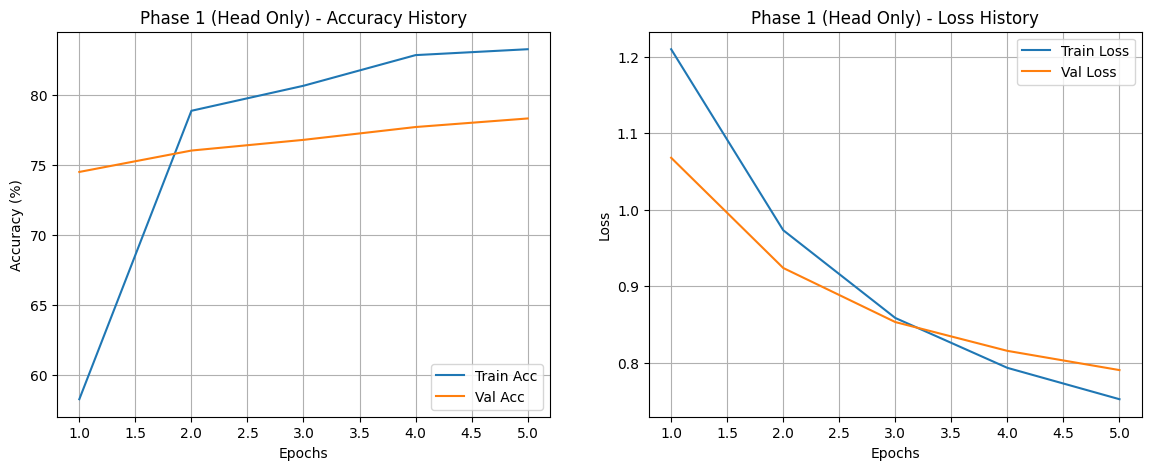


>>> Đang đánh giá trên tập Test cho Phase 1 (Head Only)...

Classification Report:
              precision    recall  f1-score   support

      glioma       0.84      0.84      0.84       160
  meningioma       0.68      0.52      0.59       137
     notumor       0.85      0.96      0.90       209
   pituitary       0.87      0.91      0.89       150

    accuracy                           0.83       656
   macro avg       0.81      0.81      0.81       656
weighted avg       0.82      0.83      0.82       656



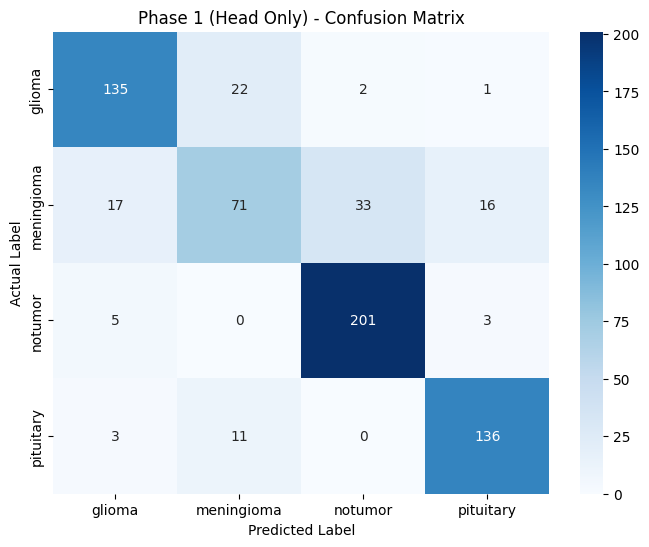

In [14]:
# === GỌI HÀM ĐÁNH GIÁ GIAI ĐOẠN 1 ===
evaluate_phase(model, history_phase1, test_loader, train_dataset.classes, phase_name="Phase 1 (Head Only)")

## Fine-tuning (Unfreeze)

In [15]:
# GIAI ĐOẠN 2: FINE-TUNING ---
print("\n>>> BẮT ĐẦU STAGE 2: FINE-TUNING...")

# Unfreeze model
for param in model.parameters():
    param.requires_grad = True
# Cấu hình Hyperparameters 
num_epochs = 40
base_lr = 3e-5 

#  Cấu hình lại Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=1e-4) # LR nhỏ hơn 10x

scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

#  Reset history 
history_phase2 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Early Stopping
early_stopping = EarlyStopping(patience=10, verbose=True, path='best_model_phase2.pth')

#TRAINING PHASE 2
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    scheduler.step()
    
    history_phase2['train_loss'].append(train_loss)
    history_phase2['train_acc'].append(train_acc)
    history_phase2['val_loss'].append(val_loss)
    history_phase2['val_acc'].append(val_acc)
    
    print(f"Fine-tune Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} Acc Train: {train_acc:.2f}% | Val Loss: {val_loss:.4f} Acc Val: {val_acc:.2f}%")
    
    # Check Early Stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# Load lại model tốt nhất của Phase 2
model.load_state_dict(torch.load('best_model_phase2.pth'))


>>> BẮT ĐẦU STAGE 2: FINE-TUNING...
Fine-tune Epoch 1/40 | Train Loss: 0.6012 Acc Train: 88.99% | Val Loss: 0.5951 Acc Val: 86.11%
Validation loss decreased (inf --> 0.595062).  Saving model ...
Fine-tune Epoch 2/40 | Train Loss: 0.5075 Acc Train: 93.28% | Val Loss: 0.4883 Acc Val: 93.13%
Validation loss decreased (0.595062 --> 0.488282).  Saving model ...
Fine-tune Epoch 3/40 | Train Loss: 0.4599 Acc Train: 95.55% | Val Loss: 0.4337 Acc Val: 96.64%
Validation loss decreased (0.488282 --> 0.433694).  Saving model ...
Fine-tune Epoch 4/40 | Train Loss: 0.4379 Acc Train: 97.04% | Val Loss: 0.4173 Acc Val: 97.56%
Validation loss decreased (0.433694 --> 0.417341).  Saving model ...
Fine-tune Epoch 5/40 | Train Loss: 0.4178 Acc Train: 97.60% | Val Loss: 0.3981 Acc Val: 98.32%
Validation loss decreased (0.417341 --> 0.398098).  Saving model ...
Fine-tune Epoch 6/40 | Train Loss: 0.4072 Acc Train: 98.53% | Val Loss: 0.3865 Acc Val: 98.63%
Validation loss decreased (0.398098 --> 0.386461).  S

<All keys matched successfully>


FINAL TEST ACCURACY: 99.70%


==================== KẾT QUẢ PHASE 2 (FINE-TUNING) ====================


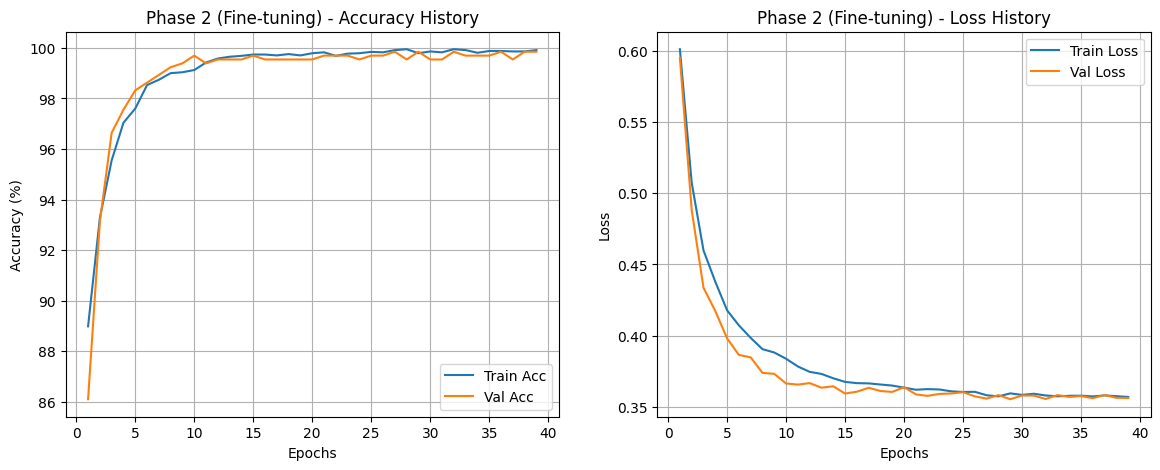


>>> Đang đánh giá trên tập Test cho Phase 2 (Fine-tuning)...

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      1.00       160
  meningioma       0.99      1.00      0.99       137
     notumor       1.00      1.00      1.00       209
   pituitary       1.00      0.99      1.00       150

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656



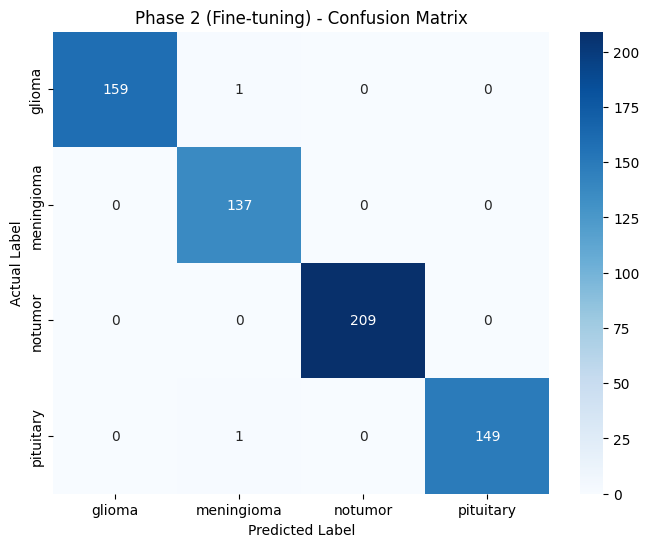

In [16]:
# ---  Tạo hàm lấy dự đoán ---
from sklearn.metrics import accuracy_score
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Dự đoán
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Lưu lại kết quả vào list
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())  
    return all_labels, all_preds
true_labels, pred_labels = get_predictions(model, test_loader)
test_accuracy = accuracy_score(true_labels, pred_labels)
print("\n" + "="*40)
print(f"FINAL TEST ACCURACY: {test_accuracy * 100:.2f}%")
print("="*40 + "\n")
evaluate_phase(model, history_phase2, test_loader, train_dataset.classes, phase_name="Phase 2 (Fine-tuning)")

## Grad Cam

In [17]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-v1hdgu1o
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-v1hdgu1o
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43670 sha256=c5402704ddb88d03616e0c1429ad394643a4477646c708d013671d8b38f3dbe0
  Stored in directory: /tmp/pip-ephem-wheel-cache-rjmbrz0q/wheels/69/29/f7/3abdb24031a22af044df15784c8a00f56b6e24f5924e33d0e8
Successfully built grad-cam


Đang tìm ảnh đại diện cho từng lớp...


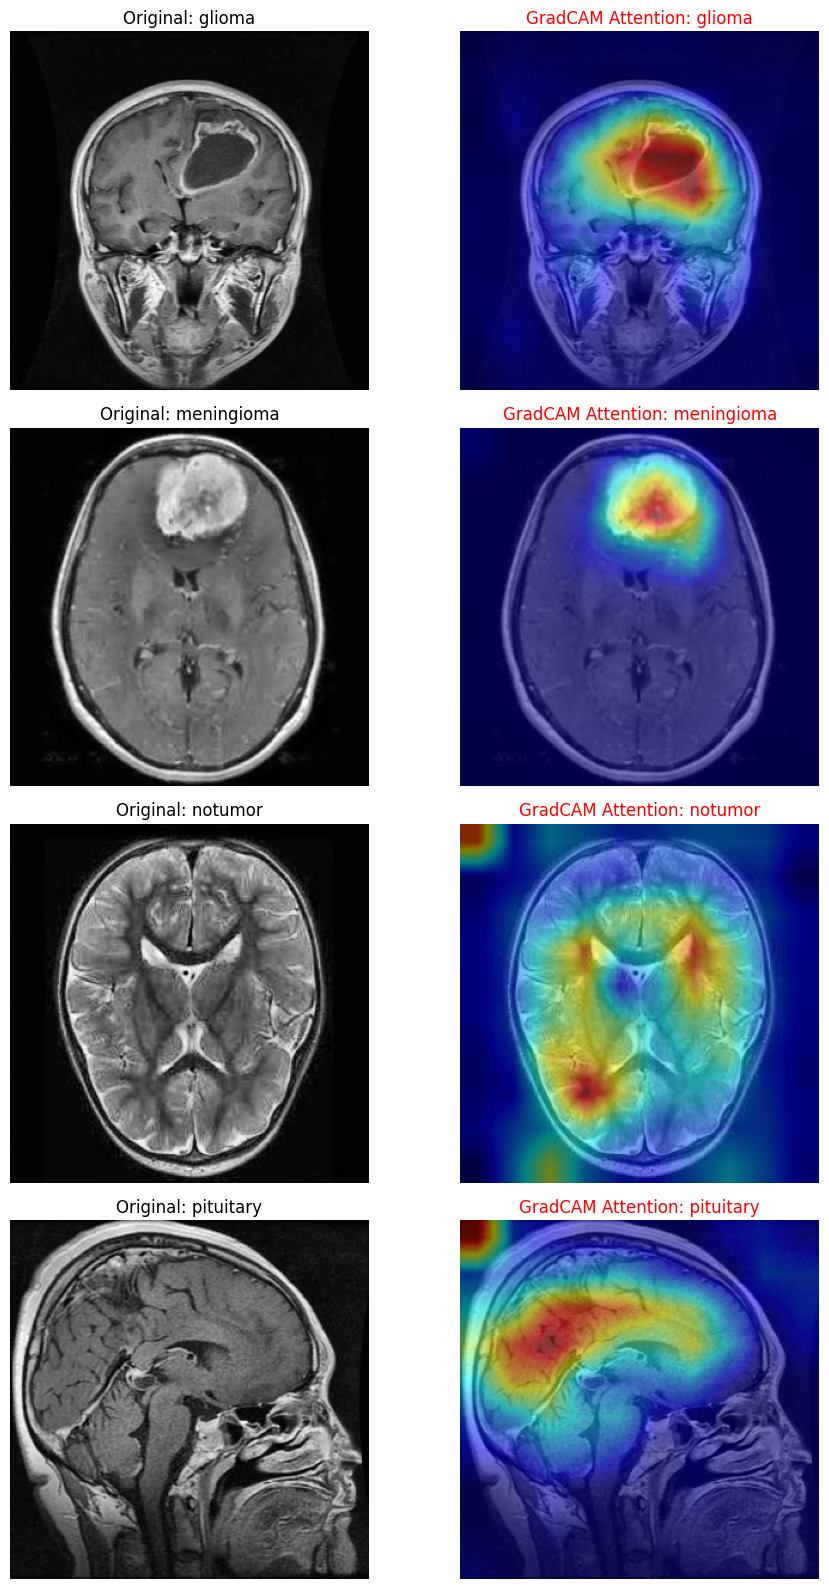

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms

def visualize_all_classes_gradcam(model, dataset, device):
    model.eval()
    
    # Tìm index đại diện cho mỗi lớp
    found_indices = {} 
    required_labels = {0, 1, 2, 3} 
    
    print("Đang tìm ảnh đại diện cho từng lớp...")
    
    # Duyệt tối đa 300 ảnh để tìm cho nhanh
    limit = min(len(dataset), 300)
    
    for i in range(limit):
        _, label = dataset[i]
        
        # XỬ LÝ LABEL: Nếu là Tensor One-hot hoặc Tensor Index thì chuyển về int
        if isinstance(label, torch.Tensor):
            if label.ndim > 0 and len(label) > 1: # One-hot
                label_idx = torch.argmax(label).item()
            else: # Index tensor
                label_idx = label.item()
        else:
            label_idx = int(label)
            
        if label_idx in required_labels and label_idx not in found_indices:
            found_indices[label_idx] = i
        
        if len(found_indices) == 4:
            break
            
    if len(found_indices) == 0:
        print("LỖI: Không tìm thấy ảnh nào. Kiểm tra lại dataset!")
        return

    # Lấy tên class
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    if hasattr(dataset, 'class_names'): # Nếu dataset có thuộc tính này
        class_names = dataset.class_names

    #  Vẽ biểu đồ
    fig, axes = plt.subplots(nrows=len(found_indices), ncols=2, figsize=(10, 4 * len(found_indices)))
    
    # Đảm bảo axes luôn là mảng 2 chiều
    if len(found_indices) == 1: axes = [axes]

    # Target Layer: Block cuối cùng của Features
    target_layers = [model.features[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)

    for row_idx, (label_idx, index) in enumerate(sorted(found_indices.items())):
        img_tensor, _ = dataset[index]
        class_name = class_names[label_idx]
        
        # ---  Chạy GradCAM ---
        input_tensor = img_tensor.unsqueeze(0).to(device)
        targets = [ClassifierOutputTarget(label_idx)]
        
        # Tạo mask grayscale
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        
        # --- Chuẩn bị ảnh nền để hiển thị ---
        # Inverse Normalize từ [-1, 1] về [0, 1]
        # Công thức: (img + 1) / 2
        rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
        rgb_img = (rgb_img + 1.0) / 2.0
        rgb_img = np.clip(rgb_img, 0, 1) # Đảm bảo nằm trong [0, 1]
        
        # ---  Chồng Heatmap lên ảnh ---
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        # Hiển thị
        ax_orig = axes[row_idx][0] if len(found_indices) > 1 else axes[0]
        ax_cam = axes[row_idx][1] if len(found_indices) > 1 else axes[1]
        
        ax_orig.imshow(rgb_img)
        ax_orig.set_title(f"Original: {class_name}", fontsize=12)
        ax_orig.axis('off')
        
        ax_cam.imshow(visualization)
        ax_cam.set_title(f"GradCAM Attention: {class_name}", fontsize=12, color='red')
        ax_cam.axis('off')

    plt.tight_layout()
    plt.show()

visualize_all_classes_gradcam(model, test_dataset, device)

## Thông tin ảnh bị dự đoán sai

Tìm thấy 2 ảnh sai. Đang hiển thị...


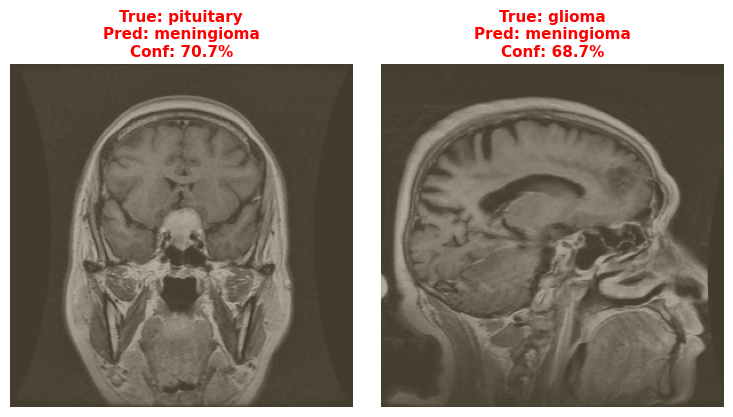

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

def show_misclassified_images(model, loader, classes, num_images=8):
    model.eval()
    
    misclassified_images = []
    
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Tính xác suất
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidence, preds = torch.max(probs, 1)
            
            # Tìm những index mà dự đoán khác nhãn thật
            idxs_mask = ((preds == labels) == False).nonzero(as_tuple=False)
            
            for idx in idxs_mask:
                idx = idx.item() # Lấy index cụ thể trong batch
                
                # Lưu thông tin ảnh sai
                misclassified_images.append({
                    'img_tensor': images[idx].cpu(),
                    'true_label': classes[labels[idx].item()],
                    'pred_label': classes[preds[idx].item()],
                    'confidence': confidence[idx].item()
                })
                
                # Nếu tìm đủ số lượng muốn hiển thị thì dừng cho nhanh
                if len(misclassified_images) >= num_images:
                    break
            
            if len(misclassified_images) >= num_images:
                break


    print(f"Tìm thấy {len(misclassified_images)} ảnh sai. Đang hiển thị...")
    
    cols = 4
    rows = (len(misclassified_images) + cols - 1) // cols
    
    plt.figure(figsize=(15, 4 * rows))
    
    for i, info in enumerate(misclassified_images):
        ax = plt.subplot(rows, cols, i + 1)
        
  
        img = inv_normalize(info['img_tensor'])
        img = img.permute(1, 2, 0).numpy() 
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        

        # Màu đỏ để nhấn mạnh lỗi sai
        title_text = f"True: {info['true_label']}\nPred: {info['pred_label']}\nConf: {info['confidence']*100:.1f}%"
        plt.title(title_text, color='red', fontsize=11, fontweight='bold')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary'] 

show_misclassified_images(model, test_loader, class_names, num_images=12)